In [23]:
import pandas as pd
import random

from transformers import pipeline, AutoTokenizer
data = pd.read_csv("campaign_data.csv")

In [4]:
pip install google-generativeai

  Using cached google_generativeai-0.8.3-py3-none-any.whl (160 kB)
  Using cached google_ai_generativelanguage-0.6.10-py3-none-any.whl (760 kB)
  Using cached google_api_core-2.23.0-py3-none-any.whl (156 kB)
  Using cached google_api_python_client-2.154.0-py2.py3-none-any.whl (12.6 MB)
  Using cached proto_plus-1.25.0-py3-none-any.whl (50 kB)
  Using cached googleapis_common_protos-1.66.0-py2.py3-none-any.whl (221 kB)
  Using cached httplib2-0.22.0-py3-none-any.whl (96 kB)
  Using cached google_auth_httplib2-0.2.0-py2.py3-none-any.whl (9.3 kB)
  Using cached grpcio_status-1.68.1-py3-none-any.whl (14 kB)
  Using cached grpcio-1.68.1-cp310-cp310-win_amd64.whl (4.4 MB)
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.58.0
    Uninstalling grpcio-1.58.0:
      Successfully uninstalled grpcio-1.58.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.26.4 which is incompatible.
tensorflow-intel 2.13.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.0 which is incompatible.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.11.0 which is incompatible.


In [5]:
from dotenv import load_dotenv
import os
load_dotenv()
api_key = os.getenv("API_KEY")

import google.generativeai as palm
palm.configure(api_key=api_key)

model = palm.GenerativeModel('gemini-1.5-flash')

def gpt_insights(campaign_text):
    try:
      response=model.generate_content(
                    f"Analyze the campaign performance described as follows: {campaign_text}. "
        "Provide insights to improve the campaign, focusing on better ad copy and targeting."
                           )
      extracted_text = response.candidates[0].content.parts[0].text
      return extracted_text

    except Exception as e:
        print(f"Error generating itinerary: {e}")
        return None


In [7]:
def gpt_anamoly_insights(campaign_text):
    try:
      response=model.generate_content(
                    f"Analyze the campaign performance described as follows: {campaign_text}. "
        "Based on the statistics , look for any anamolies that may be occuring in the advertising campaign."
                           )
      extracted_text = response.candidates[0].content.parts[0].text
      return extracted_text

    except Exception as e:
        print(f"Error generating itinerary: {e}")
        return None


In [8]:
def calculate_ctr(clicks, impressions):
    return (clicks / impressions) * 100 if impressions > 0 else 0

def calculate_roas(revenue, spend):
    return revenue / spend if spend > 0 else 0

def calculate_cpa(spend, conversions):
    return spend / conversions if conversions > 0 else float('inf')



In [24]:

def analyze_batch(data_batch, target_cpa=15):
    decisions = []
    for _, row in data_batch.iterrows():
        ctr = calculate_ctr(row["Clicks"], row["Impressions"])
        roas = calculate_roas(row["Revenue"], row["Spend"])
        cpa = calculate_cpa(row["Spend"], row["Conversions"])


        print(f"Campaign {row['Campaign ID']} - CTR: {ctr:.2f}%, ROAS: {roas:.2f}, CPA: {cpa:.2f}")

        # Apply rules for actions
        if ctr < 1 or cpa > 3 * target_cpa:
            decision = "Pause"
        elif roas > 4:
            decision = "Increase Budget"
        elif roas < 1.5:
            decision = "Decrease Budget"
        else:
            decision = "No Action"

        campaign_info = (
            f"CTR: {ctr:.2f}%, ROAS: {roas:.2f}, CPA: {cpa:.2f}, Spend: {row['Spend']}, "
            f"Revenue: {row['Revenue']}, Current Status: {row['Status']}"
        )
        insights = gpt_insights(campaign_info)
        anamoly = gpt_anamoly_insights(campaign_info)
        decisions.append([row["Campaign ID"], decision, insights,anamoly])

    return pd.DataFrame(decisions, columns=["Campaign ID", "Action", "LLM Insights","Possible Anamolies"])



In [25]:

def analyze_campaigns_in_batches(data, batch_size=3, target_cpa=15):
    total_batches = (len(data) + batch_size - 1) // batch_size
    all_decisions = []

    for batch_num in range(total_batches):
        start_idx = batch_num * batch_size
        end_idx = min(start_idx + batch_size, len(data))
        data_batch = data.iloc[start_idx:end_idx]

        print(f"Processing batch {batch_num + 1}/{total_batches} ({len(data_batch)} rows)")
        batch_decisions = analyze_batch(data_batch, target_cpa)
        all_decisions.append(batch_decisions)


    return pd.concat(all_decisions, ignore_index=True)

batch_size = 3
target_cpa = 15
report = analyze_campaigns_in_batches(data, batch_size, target_cpa)

report.to_csv("campaign_report.csv", index=False)
print("Batch processing completed! Results saved in 'campaign_report.csv'.")


Processing batch 1/4 (3 rows)
Campaign campaign_1 - CTR: 55.75%, ROAS: 2.87, CPA: 0.86
Campaign campaign_2 - CTR: 66.51%, ROAS: 1.29, CPA: 21.28
Campaign campaign_3 - CTR: 28.71%, ROAS: 0.49, CPA: 0.67
Processing batch 2/4 (3 rows)
Campaign campaign_4 - CTR: 19.30%, ROAS: 2.38, CPA: 3.93
Campaign campaign_5 - CTR: 64.72%, ROAS: 2.36, CPA: 3.29
Campaign campaign_6 - CTR: 45.42%, ROAS: 0.11, CPA: 1.40
Processing batch 3/4 (3 rows)
Campaign campaign_7 - CTR: 24.59%, ROAS: 1.77, CPA: 2.98
Campaign campaign_8 - CTR: 64.52%, ROAS: 0.15, CPA: 2.08
Campaign campaign_9 - CTR: 50.42%, ROAS: 0.36, CPA: 3.21
Processing batch 4/4 (1 rows)
Campaign campaign_10 - CTR: 87.52%, ROAS: 2.57, CPA: 4.06
Batch processing completed! Results saved in 'campaign_report.csv'.


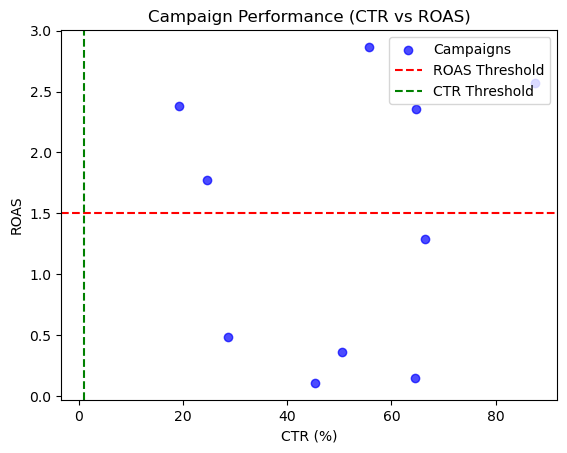

In [26]:
import matplotlib.pyplot as plt


data["CTR"] = data.apply(lambda row: calculate_ctr(row["Clicks"], row["Impressions"]), axis=1)
data["ROAS"] = data.apply(lambda row: calculate_roas(row["Revenue"], row["Spend"]), axis=1)

plt.scatter(data["CTR"], data["ROAS"], c="blue", alpha=0.7, label="Campaigns")
plt.axhline(y=1.5, color="red", linestyle="--", label="ROAS Threshold")
plt.axvline(x=1, color="green", linestyle="--", label="CTR Threshold")
plt.xlabel("CTR (%)")
plt.ylabel("ROAS")
plt.title("Campaign Performance (CTR vs ROAS)")
plt.legend()
plt.show()


In [27]:
import requests

def execute_actions(report):
    for _, row in report.iterrows():
        campaign_id = row["Campaign ID"]
        action = row["Action"]
        


In [28]:
def generate_daily_report(report, original_data):
    merged = pd.merge(report, original_data, on="Campaign ID")
    merged.to_csv("daily_summary_report.csv", index=False)
    print("Daily Summary Report generated: 'daily_summary_report.csv'")

import sqlite3
def store_historical_data(data):
    conn = sqlite3.connect("campaign_history.db")
    data.to_sql("campaigns", conn, if_exists="append", index=False)
    conn.close()
    print("Historical data stored in SQLite database.")
data["CTR"] = data.apply(lambda row: calculate_ctr(row["Clicks"], row["Impressions"]), axis=1)
data["ROAS"] = data.apply(lambda row: calculate_roas(row["Revenue"], row["Spend"]), axis=1)

print(data[["Clicks", "Impressions", "CTR","ROAS"]].head())



   Clicks  Impressions        CTR      ROAS
0    1880         3372  55.753262  2.866661
1    1007         1514  66.512550  1.288776
2    1556         5420  28.708487  0.489445
3     646         3347  19.300866  2.377800
4    1576         2435  64.722793  2.355119


In [29]:
execute_actions(report)
generate_daily_report(report, data)


Daily Summary Report generated: 'daily_summary_report.csv'


In [30]:
def gpt_top_campaign_insights(data):
    top_campaigns = data[data["ROAS"] > 2].head(3)  # Top-performing campaigns
    print("Top Campaigns",top_campaigns)
    insights = []
    for _, row in top_campaigns.iterrows():
        campaign_info = f"Ad Copy for Campaign {row['Campaign ID']} with ROAS {row['ROAS']:.2f}."
        result = gpt_insights(campaign_info)
        insights.append({"Campaign ID": row["Campaign ID"], "Insights": result})
    return pd.DataFrame(insights)


In [31]:
def store_historical_data(data):
    conn = sqlite3.connect("campaign_history.db")
    data.to_sql("campaigns", conn, if_exists="append", index=False)
    conn.close()
    print("Historical data stored in SQLite database.")
store_historical_data(data)


Historical data stored in SQLite database.


In [32]:
target_cpa = 15
store_historical_data(data)
top_insights = gpt_top_campaign_insights(data)
print(top_insights)
top_insights.to_csv("top_campaign_insights.csv", index=False)
print("Top campaign insights saved: 'top_campaign_insights.csv'")




Historical data stored in SQLite database.
Top Campaigns   Campaign ID  Impressions  Clicks  Conversions   Spend  Revenue  Status  \
0  campaign_1         3372    1880          128  110.32   316.25  Active   
3  campaign_4         3347     646           45  176.76   420.30  Paused   
4  campaign_5         2435    1576          147  483.50  1138.70  Paused   

         CTR      ROAS  
0  55.753262  2.866661  
3  19.300866  2.377800  
4  64.722793  2.355119  
  Campaign ID                                           Insights
0  campaign_1  A ROAS (Return on Ad Spend) of 2.87 for campai...
1  campaign_4  A ROAS (Return on Ad Spend) of 2.38 for campai...
2  campaign_5  A ROAS (Return on Ad Spend) of 2.36 for campai...
Top campaign insights saved: 'top_campaign_insights.csv'


In [33]:
import plotly.express as px


# Plot ROAS Trends
def visualize_roas_trends(data):
    fig = px.line(data, x="Campaign ID", y="ROAS", title="ROAS Trends by Campaign")
    fig.update_traces(marker=dict(size=12))
    fig.show()


import plotly.express as px

STATUS_COLOR_MAP = {
    "Active": "blue",
    "Paused": "red",
    "Completed": "green",
    "Draft": "orange"  
}

# Visualize CTR and ROAS with better color differentiation
def visualize_ctr_vs_roas(data):
    fig = px.scatter(
        data,
        x="CTR",
        y="ROAS",
        color="Status",
        title="CTR vs ROAS for Campaigns",
        labels={"CTR": "Click-Through Rate", "ROAS": "Return on Ad Spend"},
        color_discrete_map=STATUS_COLOR_MAP  
    )
    fig.show()



In [34]:

visualize_roas_trends(data)

In [35]:
visualize_ctr_vs_roas(data)


In [38]:
data.to_csv("new_csv.csv", index=False)

In [36]:

!pip install streamlit
!pip install jupyter-dash

In [37]:
import pandas as pd
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import dcc, html
from dash.dependencies import Input, Output
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Initialize the JupyterDash app
app = JupyterDash(__name__)

# App layout
app.layout = html.Div([
    html.H1("Campaign Performance Dashboard", style={"textAlign": "center", "color": "#333"}),
    html.Div([
        html.Div([
            html.Label("Select Campaign(s):", style={"fontWeight": "bold"}),
            dcc.Dropdown(
                id="campaign-filter",
                options=[{"label": campaign, "value": campaign} for campaign in data["Campaign ID"].unique()],
                value=data["Campaign ID"].unique(),
                multi=True
            )
        ], style={"width": "45%", "display": "inline-block"}),

        html.Div([
            html.Label("Select Status:", style={"fontWeight": "bold"}),
            dcc.Dropdown(
                id="status-filter",
                options=[{"label": status, "value": status} for status in data["Status"].unique()],
                value=data["Status"].unique(),
                multi=True
            )
        ], style={"width": "45%", "display": "inline-block", "marginLeft": "10px"})
    ]),

    html.Div(id="filtered-data-table", style={"marginTop": "20px"}),

    html.H2("Click-Through Rate (CTR) by Campaign", style={"textAlign": "center", "color": "#444"}),
    dcc.Graph(id="ctr-graph"),

    html.H2("Return on Ad Spend (ROAS) by Campaign", style={"textAlign": "center", "color": "#444"}),
    dcc.Graph(id="roas-graph"),

    html.H2("Spend and Revenue Trends", style={"textAlign": "center", "color": "#444"}),
    dcc.Graph(id="spend-trends-graph")
])

# Callbacks for interactivity
@app.callback(
    [
        Output("filtered-data-table", "children"),
        Output("ctr-graph", "figure"),
        Output("roas-graph", "figure"),
        Output("spend-trends-graph", "figure")
    ],
    [
        Input("campaign-filter", "value"),
        Input("status-filter", "value")
    ]
)
def update_dashboard(selected_campaigns, selected_status):
    # Filter data
    filtered_data = data[
        (data["Campaign ID"].isin(selected_campaigns)) &
        (data["Status"].isin(selected_status))
    ]

    # Data table
    data_table = html.Div([
        html.H4("Filtered Campaign Data", style={"color": "#333"}),
        html.Table([
            html.Thead(html.Tr([html.Th(col, style={"border": "1px solid #ddd", "padding": "8px"}) for col in filtered_data.columns])),
            html.Tbody([
                html.Tr([html.Td(row[col], style={"border": "1px solid #ddd", "padding": "8px"}) for col in filtered_data.columns])
                for _, row in filtered_data.iterrows()
            ])
        ], style={"width": "100%", "borderCollapse": "collapse", "color": "#444"})
    ])

    # CTR graph
    ctr_fig = px.bar(
        filtered_data,
        x="Campaign ID",
        y="CTR",
        color="Status",
        title="CTR by Campaign",
        labels={"CTR": "Click-Through Rate (%)"},
        color_discrete_sequence=px.colors.qualitative.Set1
    )

    # ROAS graph
    roas_fig = px.bar(
        filtered_data,
        x="Campaign ID",
        y="ROAS",
        color="Status",
        title="ROAS by Campaign",
        labels={"ROAS": "Return on Ad Spend"},
        color_discrete_sequence=px.colors.qualitative.Set2
    )

    # Spend vs Revenue trends
    spend_fig = px.line(
        filtered_data,
        x="Campaign ID",
        y=["Spend", "Revenue"],
        title="Spend vs Revenue",
        labels={"value": "Amount", "variable": "Metric"},
        markers=True,
        color_discrete_sequence=px.colors.qualitative.Plotly
    )

    return data_table, ctr_fig, roas_fig, spend_fig

# Run the app in the notebook
app.run_server(mode="external", port=8050)


TypeError: 'NoneType' object cannot be interpreted as an integer